In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [ ]:
# create  an object using Vgg16 architecture

vgg16_model = tf.keras.applications.vgg16.VGG16(input_shape=(150,150,3), 
                                                    include_top=False,  # Loads only convolutional layers, not the dense layers on top
                                                    weights='imagenet'  # Loads weights from imagenet
                                                    )



In [ ]:
# Make convolutional layers untrainable

  for layer in vgg16_model.layers:
    layer.trainable = False

  

In [ ]:
# Study the architecture

vgg16_model.summary()

# Documentation available at: https://keras.io/api/applications/inceptionv3/




Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Pick a layer whose ouputput can be fed into a dense layer that we will train using the cats-v-dogs images.
I will go with block5_pool (MaxPooling2D)

In [ ]:
#  Check the output of block5_pool 

vgg16_model_block5_pool = vgg16_model.get_layer('block5_pool')

print ('shape of block5_pool :',vgg16_model_block5_pool.output_shape )




shape of block5_pool : (None, 4, 4, 512)


In [ ]:
# capture the output of mixed6 layer

vgg16_model_output = vgg16_model_block5_pool.output


In [ ]:
# Build you own dense layer

# Flatten the output of the inception model
custom_dense_layer = tf.keras.layers.Flatten()(vgg16_model_output)

# Add a dense layer of 1024 neurons with relu activation

custom_dense_layer = tf.keras.layers.Dense(1024,activation='relu') (custom_dense_layer)

# Add an output layer with 1 neuron (binary classification) with sigmoid activation

custom_dense_layer = tf.keras.layers.Dense(1,activation='sigmoid') (custom_dense_layer)


In [ ]:
# Build a new model object comprising of the inception model and custom dense layer

model = tf.keras.Model(vgg16_model.input,custom_dense_layer)

In [ ]:
# compile with model

model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Check out the summary

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)      

In [ ]:
# Get cats and dogs data set and unzip it

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

import zipfile
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2020-10-22 07:03:01--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.9.208, 172.217.12.240, 172.217.13.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.9.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  95.2MB/s    in 0.7s    

2020-10-22 07:03:02 (95.2 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
# Build a training using Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen_augmented = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,        # rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures
      width_shift_range=0.3,    # width_shift is a range (fraction of total width) within  which the picture is  horizontally translated
      height_shift_range=0.3,   # height_shift is a range (fraction of total heigth) within  which the picture is  vertically translated
      shear_range=0.3,          # shear_range is for randomly applying shearing transformations.
      zoom_range=0.3,           # zoom_range is for randomly zooming inside pictures
      horizontal_flip=True,     # Horizontal_flip is for randomly flipping half of the images horizontally.
      fill_mode='nearest' )     # strategy used for filling in newly created pixels



training_images_path = '/tmp/cats_and_dogs_filtered/train'

train_generator_augmented = train_datagen_augmented.flow_from_directory(
    training_images_path, 
    target_size=(150, 150), # resize images to 150 x 150
    batch_size = 20, 
    class_mode='binary' # This is a binary classifier cats and dogs
)



Found 2000 images belonging to 2 classes.


In [ ]:
# Build a validation generator

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

validation_images_path = '/tmp/cats_and_dogs_filtered/validation'

validation_generator = validation_datagen.flow_from_directory(
    validation_images_path, 
    target_size=(150, 150), # resize images to 150 x 150
    batch_size = 20, 
    class_mode='binary' # This is a binary classifier cats and dogs
)

Found 1000 images belonging to 2 classes.


In [ ]:
# Fitting the model and saving the output of each epoch in an object named " history"

history = model.fit(
      train_generator_augmented,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/100
100/100 - 18s - loss: 0.2020 - accuracy: 0.9190 - val_loss: 0.3035 - val_accuracy: 0.8960
Epoch 2/100
100/100 - 18s - loss: 0.2013 - accuracy: 0.9095 - val_loss: 0.2732 - val_accuracy: 0.9040
Epoch 3/100
100/100 - 18s - loss: 0.2158 - accuracy: 0.9055 - val_loss: 0.2908 - val_accuracy: 0.8980
Epoch 4/100
100/100 - 18s - loss: 0.2127 - accuracy: 0.9115 - val_loss: 0.2894 - val_accuracy: 0.8960
Epoch 5/100
100/100 - 18s - loss: 0.2071 - accuracy: 0.9105 - val_loss: 0.2840 - val_accuracy: 0.9070
Epoch 6/100
100/100 - 18s - loss: 0.2105 - accuracy: 0.9085 - val_loss: 0.2988 - val_accuracy: 0.8930
Epoch 7/100
100/100 - 18s - loss: 0.2032 - accuracy: 0.9085 - val_loss: 0.3021 - val_accuracy: 0.8930
Epoch 8/100
100/100 - 18s - loss: 0.1969 - accuracy: 0.9165 - val_loss: 0.2775 - val_accuracy: 0.9080
Epoch 9/100
100/100 - 18s - loss: 0.2021 - accuracy: 0.9160 - val_loss: 0.2891 - val_accuracy: 0.9090
Epoch 10/100
100/100 - 18s - loss: 0.2089 - accuracy: 0.9060 - val_loss: 0.3017 - 

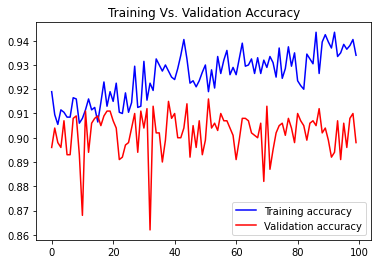

In [ ]:
# Plot the loss and accuracy using the history object

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(0,100)

# Plot training vs validation accuracy

plt.plot(epochs,acc,'b',label = 'Training accuracy')
plt.plot(epochs,val_acc,'r',label = 'Validation accuracy')
plt.title("Training Vs. Validation Accuracy")
plt.legend()
plt.show()


Training accuracy is close to 95% which is quite good. Also each epoch was just 18s which is not long at all.
This is the power of transfer learning


# DIY : Build a NN with transfer learning using VGG19

VGG19 Documentation: https://keras.io/api/applications/vgg/#vgg19-function



In [ ]:
# create  an object using Vgg16 architecture

vgg19_model = tf.keras.applications.vgg19.VGG19(input_shape=(150,150,3), 
                                                    include_top=False,  # Loads only convolutional layers, not the dense layers on top
                                                    weights='imagenet'  # Loads weights from imagenet
                                                    )


80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     